In [1]:
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *

from IPython import display

%matplotlib inline

In [2]:
# Preprocessing params
windowSize = 1024
fftSize = windowSize
hopSize = 128
windowFunction = hanning

# TDOA params
numTDOAs = 128

# NMF params
dictionarySize = 128
numIterations = 100
sparsityAlpha = 0

# Input params    
mixtureFileNamePrefix = 'G:\\speech segregation\\gcc-nmf-master\\gcc-nmf-master\\data\\dev1_female3_liverec_130ms_1m'
microphoneSeparationInMetres = 1.0
numSources = 3

In [5]:
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)

numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)
print(numChannels) 
print(numSamples)

2
160000


Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


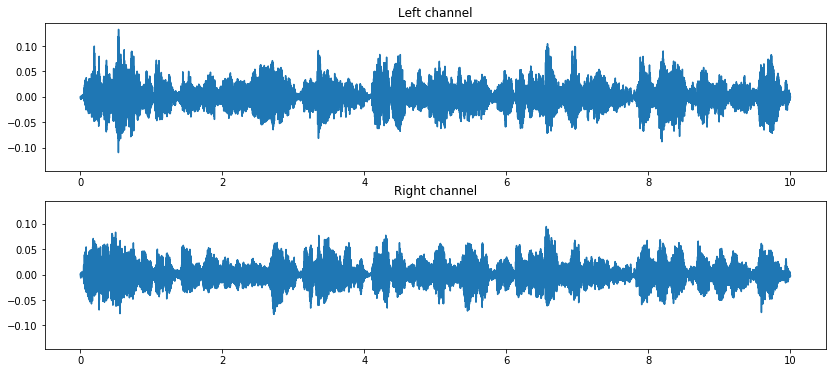

In [4]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

display.display( display.Audio(mixtureFileName) )

In [6]:
complexMixtureSpectrogram = computeComplexMixtureSpectrogram( stereoSamples, windowSize,
                                                              hopSize, windowFunction ) 
numChannels, numFrequencies, numTime = complexMixtureSpectrogram.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

STFT:
	windowSize: 1024
	hopSize: 128
	windowFunction: <function hanning at 0x0000027322F63840>
	complexMixtureSpectrogram.shape = (numChannels, numFreq, numWindows): (2, 513, 1243)
	complexMixtureSpectrogram.dtype = complex64


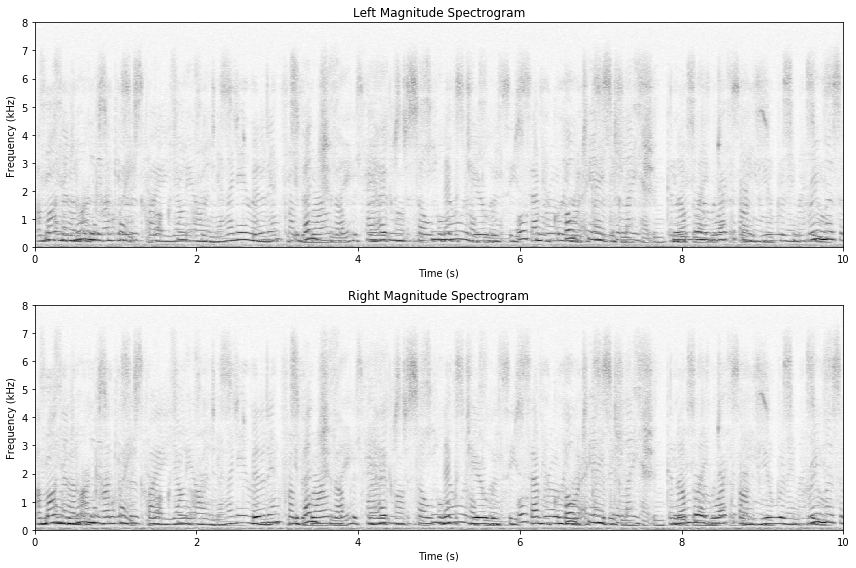

In [7]:
describeMixtureSpectrograms(windowSize, hopSize, windowFunction, complexMixtureSpectrogram)

figure(figsize=(12, 8))
plotMixtureSpectrograms(complexMixtureSpectrogram, frequenciesInkHz, durationInSeconds)

In [8]:
spectralCoherenceV = complexMixtureSpectrogram[0] * complexMixtureSpectrogram[1].conj() \
                     / abs(complexMixtureSpectrogram[0]) / abs(complexMixtureSpectrogram[1])
angularSpectrogram = getAngularSpectrogram( spectralCoherenceV, frequenciesInHz,
                                            microphoneSeparationInMetres, numTDOAs )
meanAngularSpectrum = mean(angularSpectrogram, axis=-1) 
targetTDOAIndexes = estimateTargetTDOAIndexesFromAngularSpectrum( meanAngularSpectrum,
                                                                  microphoneSeparationInMetres,
                                                                  numTDOAs, numSources)

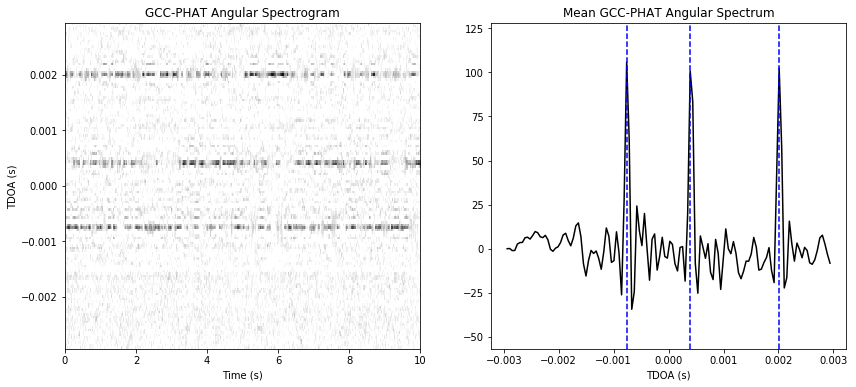

In [9]:
figure(figsize=(14, 6))
plotGCCPHATLocalization( spectralCoherenceV, angularSpectrogram, meanAngularSpectrum,
                         targetTDOAIndexes, microphoneSeparationInMetres, numTDOAs,
                         durationInSeconds )

In [10]:
V = concatenate( abs(complexMixtureSpectrogram), axis=-1 )
W, H = performKLNMF(V, dictionarySize, numIterations, sparsityAlpha)

numChannels = stereoSamples.shape[0]
stereoH = array( hsplit(H, numChannels) )

Input V:
    V.shape = (numFreq, numWindows): (513, 2486)
    V.dtype = float32
Dictionary W:
    W.shape = (numFreq, numAtoms): (513, 128)
    W.dtype = float32
Coefficients H:
    H.shape = (numAtoms, numWindows): (128, 2486)
    H.dtype = float32


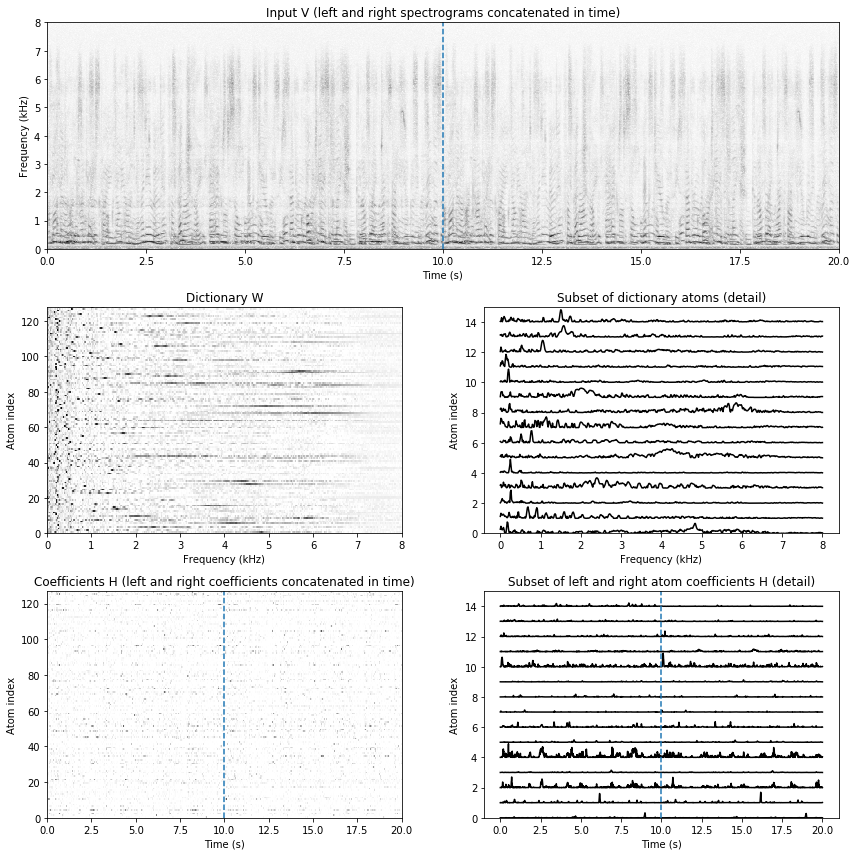

In [11]:
describeNMFDecomposition(V, W, H)

figure(figsize=(12, 12))
plotNMFDecomposition(V, W, H, frequenciesInkHz, durationInSeconds, numAtomsToPlot=15)

In [12]:
targetTDOAGCCNMFs = getTargetTDOAGCCNMFs( spectralCoherenceV, microphoneSeparationInMetres,
                                          numTDOAs, frequenciesInHz, targetTDOAIndexes, W,
                                          stereoH )
targetCoefficientMasks = getTargetCoefficientMasks(targetTDOAGCCNMFs, numSources)

G:\speech segregation\gcc-nmf-master\gcc-nmf-master\gccNMF\gccNMFPlotting.py:180: RuntimeWarning: invalid value encountered in sqrt
  imshow( (targetCoefficientMask * stereoH[0]) ** hRootFactor, cmap=cm.binary,
G:\speech segregation\gcc-nmf-master\gcc-nmf-master\gccNMF\gccNMFPlotting.py:187: RuntimeWarning: invalid value encountered in sqrt
  imshow( (targetCoefficientMask * stereoH[1]) ** hRootFactor, cmap=cm.binary,


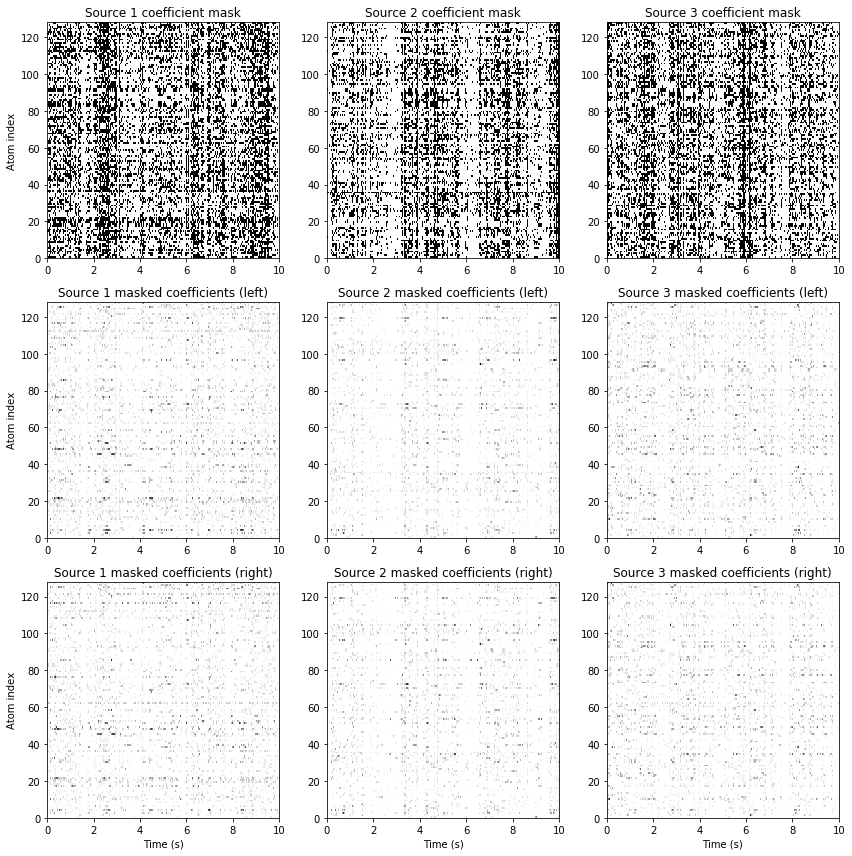

In [13]:
figure(figsize=(12, 12))
plotCoefficientMasks(targetCoefficientMasks, stereoH, durationInSeconds)

In [14]:
targetSpectrogramEstimates = getTargetSpectrogramEstimates( targetCoefficientMasks,
                                                            complexMixtureSpectrogram, W,
                                                            stereoH )

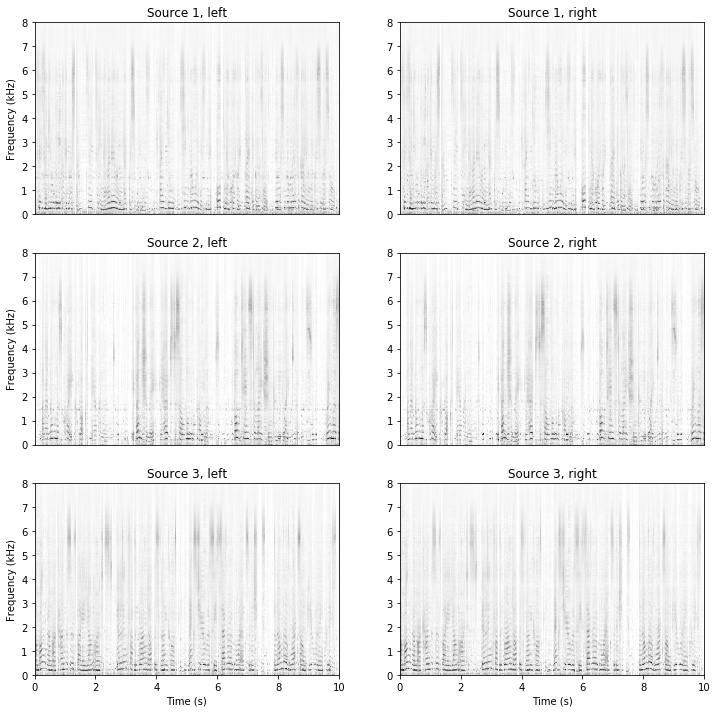

In [15]:
figure(figsize=(12, 12))
plotTargetSpectrogramEstimates(targetSpectrogramEstimates, durationInSeconds, frequenciesInkHz)

In [16]:
targetSignalEstimates = getTargetSignalEstimates( targetSpectrogramEstimates, windowSize,
                                                  hopSize, windowFunction )
saveTargetSignalEstimates(targetSignalEstimates, sampleRate, mixtureFileNamePrefix)

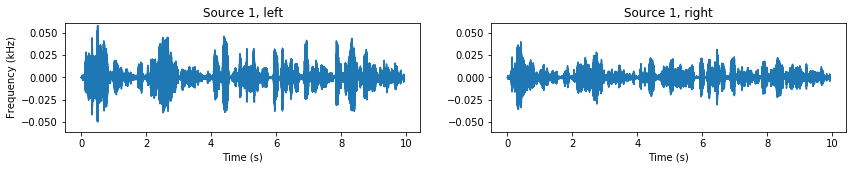

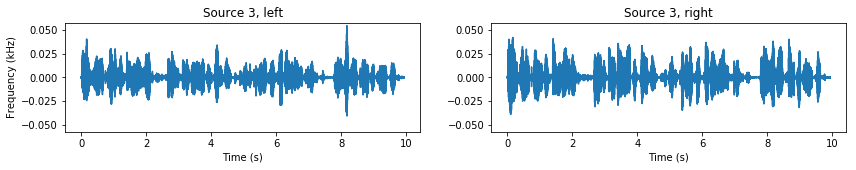

In [17]:
for sourceIndex in range(numSources):
    figure(figsize=(14, 2))
    fileName = getSourceEstimateFileName(mixtureFileNamePrefix, sourceIndex)
    plotTargetSignalEstimate( targetSignalEstimates[sourceIndex], sampleRate,
                              'Source %d' % (sourceIndex+1) )
    display.display(display.Audio(fileName))